# KITTI Dataset Exploration

In [30]:
import numpy as np
import pykitti

# Change this to the directory where you store KITTI data
basedir = 'data'

def load_dataset(date, drive, calibrated=False, frame_range=None):
    """
    Loads the dataset with `date` and `drive`.
    
    Parameters
    ----------
    date        : Dataset creation date.
    drive       : Dataset drive.
    calibrated  : Flag indicating if we need to parse calibration data. Defaults to `False`.
    frame_range : Range of frames. Defaults to `None`.

    Returns
    -------
    Loaded dataset of type `raw`.
    """
    dataset = pykitti.raw(basedir, date, drive)

    # Load the data
    if calibrated:
        dataset.load_calib()  # Calibration data are accessible as named tuples

    np.set_printoptions(precision=4, suppress=True)
    print('\nDrive: ' + str(dataset.drive))
    print('\nFrame range: ' + str(dataset.frames))

    if calibrated:
        print('\nIMU-to-Velodyne transformation:\n' + str(dataset.calib.T_velo_imu))
        print('\nGray stereo pair baseline [m]: ' + str(dataset.calib.b_gray))
        print('\nRGB stereo pair baseline [m]: ' + str(dataset.calib.b_rgb))

    return dataset

In [114]:
from source import parseTrackletXML as xmlParser

def load_tracklets_for_frames(n_frames, xml_path):
    """
    Loads dataset labels also referred to as tracklets, saving them individually for each frame.

    Parameters
    ----------
    n_frames    : Number of frames in the dataset.
    xml_path    : Path to the tracklets XML.

    Returns
    -------
    Tuple of dictionaries with integer keys corresponding to absolute frame numbers and arrays as values. First array
    contains coordinates of bounding box vertices for each object in the frame, and the second array contains objects
    types as strings.
    """
    tracklets = xmlParser.parseXML(xml_path)
    print(tracklets)
    print('_________________________')
    frame_tracklets = {}
    frame_data = {}
    frame_tracklets_types = {}
    
    # Make dict for data label
    frame_data = {}
    
    print("num", n_frames)
    for i in range(n_frames):
        frame_tracklets[i] = []
        frame_tracklets_types[i] = []
        # same init as them
        frame_data[i] = []

    # loop over tracklets
    for i, tracklet in enumerate(tracklets):
        # this part is inspired by kitti object development kit matlab code: computeBox3D
        h, w, l = tracklet.size
        # in velodyne coordinates around zero point and without orientation yet
        trackletBox = np.array([
            [-l / 2, -l / 2, l / 2, l / 2, -l / 2, -l / 2, l / 2, l / 2],
            [w / 2, -w / 2, -w / 2, w / 2, w / 2, -w / 2, -w / 2, w / 2],
            [0.0, 0.0, 0.0, 0.0, h, h, h, h]
        ])
        # loop over all data in tracklet
        for translation, rotation, state, occlusion, truncation, amtOcclusion, amtBorders, absoluteFrameNumber in tracklet:
            # determine if object is in the image; otherwise continue
            
            #for i in [translation, rotation, state, occlusion, truncation, amtOcclusion, amtBorders, absoluteFrameNumber]:
            #    print(i)
            
            if truncation not in (xmlParser.TRUNC_IN_IMAGE, xmlParser.TRUNC_TRUNCATED):
                continue
            # re-create 3D bounding box in velodyne coordinate system
            yaw = rotation[2]  # other rotations are supposedly 0
            assert np.abs(rotation[:2]).sum() == 0, 'object rotations other than yaw given!'
            rotMat = np.array([
                [np.cos(yaw), -np.sin(yaw), 0.0],
                [np.sin(yaw), np.cos(yaw), 0.0],
                [0.0, 0.0, 1.0]
            ])
            cornerPosInVelo = np.dot(rotMat, trackletBox) + np.tile(translation, (8, 1)).T
            print('________________')
            print(tracklet.objectType)
            
            frame_tracklets[absoluteFrameNumber] = frame_tracklets[absoluteFrameNumber] + [cornerPosInVelo]
            frame_tracklets_types[absoluteFrameNumber] = frame_tracklets_types[absoluteFrameNumber] + [
                tracklet.objectType]
            
            axis = [0, 1]
            #print(frame_tracklets[absoluteFrameNumber][0][0])
            bbox2D = [frame_tracklets[absoluteFrameNumber][0][0][0], frame_tracklets[absoluteFrameNumber][0][1][0], \
                     frame_tracklets[absoluteFrameNumber][0][0][1], frame_tracklets[absoluteFrameNumber][0][1][1]]
            
            #w = abs(bbox2D[1] - bbox2D[3])
            #l = abs(bbox2D[0] - bbox2D[2])
            print(w, l, h)
            #print(translation)
            array_with_data = [tracklet.objectType, truncation, occlusion[1], 0] +  bbox2D + [h, w, l]
            array_with_data +=  [translation[0], translation[1], translation[2]] + [yaw]
            print(array_with_data)
            frame_data[absoluteFrameNumber].append(array_with_data)

    return (frame_tracklets, frame_tracklets_types, frame_data)

Load the dataset downloaded from [KITTI website](http://www.cvlibs.net/datasets/kitti/raw_data.php). 

[2011_09_26_drive_0001 (0.4 GB)](http://kitti.is.tue.mpg.de/kitti/raw_data/2011_09_26_drive_0001/2011_09_26_drive_0001_sync.zip)

* **Length**: 114 frames (00:11 minutes)
* **Image resolution**: `1392 x 512` pixels
* **Labels**: 12 Cars, 0 Vans, 0 Trucks, 0 Pedestrians, 0 Sitters, 2 Cyclists, 1 Trams, 0 Misc

In [115]:
date = '2011_09_26'
drive = '0001'
dataset = load_dataset(date, drive)
#print(list(dataset.velo))
#print('___________')
tracklet_rects, tracklet_types, frame_data= load_tracklets_for_frames(len(list(dataset.velo)), 'data/{}/{}_drive_{}_sync/tracklet_labels.xml'.format(date, date, drive))


Drive: 2011_09_26_drive_0001_sync

Frame range: None
Parsing tracklet file data/2011_09_26/2011_09_26_drive_0001_sync/tracklet_labels.xml
File contains 15 tracklets
Loaded 15 tracklets.
[<source.parseTrackletXML.Tracklet object at 0x7fccd53b7630>, <source.parseTrackletXML.Tracklet object at 0x7fccd53b7668>, <source.parseTrackletXML.Tracklet object at 0x7fccd53b76a0>, <source.parseTrackletXML.Tracklet object at 0x7fccd53b76d8>, <source.parseTrackletXML.Tracklet object at 0x7fccd53b7710>, <source.parseTrackletXML.Tracklet object at 0x7fccd53b7748>, <source.parseTrackletXML.Tracklet object at 0x7fccd53b7780>, <source.parseTrackletXML.Tracklet object at 0x7fccd53b77b8>, <source.parseTrackletXML.Tracklet object at 0x7fccd53b77f0>, <source.parseTrackletXML.Tracklet object at 0x7fccd53b7828>, <source.parseTrackletXML.Tracklet object at 0x7fccd53b7860>, <source.parseTrackletXML.Tracklet object at 0x7fccd80b1d30>, <source.parseTrackletXML.Tracklet object at 0x7fccd53b7898>, <source.parseTrackl

________________
Car
1.6056261 3.8312221
['Car', 0.0, 0.0, 0, 25.992221599956668, 7.694266369528907, 26.064875709139006, 9.398430130755557, 0, 1.6056261, 3.8312221, 48.37926679522441, 6.547220538136676, -1.5108162687655875, 3.0455090469940553]
________________
Car
1.6056261 3.8312221
['Car', 0.0, 0.0, 0, 24.60149253359178, 7.731304587746748, 24.67414664277412, 9.435468348973398, 0, 1.6056261, 3.8312221, 46.992362858143785, 6.644119131632759, -1.5366198216052909, 3.048020896136162]
________________
Car
1.6056261 3.8312221
['Car', 0.0, 0.0, 0, 23.236941197383373, 7.7796622283850905, 23.306945112098532, 9.483936911816079, 0, 1.6056261, 3.8312221, 45.606207901163636, 6.748998689705737, -1.6026946272567857, 3.050532745278268]
________________
Car
1.6056261 3.8312221
['Car', 0.0, 0.0, 0, 21.87238471545924, 7.828022144558892, 21.939738266419045, 9.53240362880247, 0, 1.6056261, 3.8312221, 44.220052944183486, 6.853878247778716, -1.6687694329082803, 3.0530445944203746]
________________
Car
1.605

________________
Cyclist
0.4350746 1.7023858
['Cyclist', 0.0, 0.0, 0, 62.72664171603633, -2.4855124475207946, 62.804082773520676, -4.849467737817815, 0, 0.4350746, 1.7023858, 13.832023577986332, -10.928327788962546, -1.3188440411805464, 0.0]
________________
Cyclist
0.4350746 1.7023858
['Cyclist', 0.0, 0.0, 0, 62.93588547961796, -2.4421964668507465, 63.00753755044493, -4.806334303918156, 0, 0.4350746, 1.7023858, 13.656073340632112, -10.936607314173541, -1.3095260500621693, 0.0]
________________
Cyclist
0.4350746 1.7023858
['Cyclist', 1.0, 0.0, 0, 63.19861223736817, -2.348352822440015, 63.25743690157782, -4.712844605210297, 0, 0.4350746, 1.7023858, 13.48012310327789, -10.944886839384536, -1.300208058943792, 0.0]
________________
Cyclist
0.4350746 1.7023858
['Cyclist', 1.0, 0.0, 0, 63.46168255095537, -2.25453545186231, 63.50767807704419, -4.619311581538727, 0, 0.4350746, 1.7023858, 13.355725981375846, -10.934462293263662, -1.276450206640264, 0.0]
________________
Cyclist
0.4350746 1.7023

Looking at the points distributions, we could catch something meaningful if we limit **X**, **Y** and **Z** axis to some magic numbers.

Additionally we will only visualise 20% of the point cloud, as each frame contains ~120K points.

In [111]:
print(frame_data)

{0: [['Car', 0.0, 1.0, 0, 27.33890250383678, 9.363269830657602, 27.41155661301912, 7.659106069430952, 0, 1.70416376122665, 0.07265410918233783, 25.21251603745626, 8.603391544474482, -1.7921571450416216, -3.1842001424562025], ['Car', 0.0, 0.0, 0, 27.33890250383678, 9.363269830657602, 27.41155661301912, 7.659106069430952, 0, 1.70416376122665, 0.07265410918233783, 33.648305986718775, 7.928600125939597, -1.7324060218367638, 3.070163538741692], ['Car', 0.0, 0.0, 0, 27.33890250383678, 9.363269830657602, 27.41155661301912, 7.659106069430952, 0, 1.70416376122665, 0.07265410918233783, 42.99702319072275, 7.20752116056774, -1.4932376060313826, 3.06027168177609], ['Tram', 0.0, 0.0, 0, 27.33890250383678, 9.363269830657602, 27.41155661301912, 7.659106069430952, 0, 1.70416376122665, 0.07265410918233783, 86.29707472161449, -14.472597682830635, -0.779123239144533, -0.1254837728046641], ['Car', 0.0, 0.0, 0, 27.33890250383678, 9.363269830657602, 27.41155661301912, 7.659106069430952, 0, 1.70416376122665, 

In [116]:
# save .txt
path = 'result/'

path_to_velodyne = '/home/artem/Parser/KITTI-Dataset-master/data/2011_09_26/2011_09_26_drive_0001_sync/velodyne_points/data'

def get_data(path_to_velodyne):
    import os
    X_train_test_val = os.listdir(path_to_velodyne)
    X_train_test_val.sort()
    X_train_test_val = list(map(lambda name: name[:-4], X_train_test_val))
    print(X_train_test_val)
    return X_train_test_val

names = get_data(path_to_velodyne)


for idx, frame in enumerate(frame_data):
    result_str = ''
    for list_info in frame_data[frame]:
        list_info = map(str, list_info)
        #print(list_info)
        s1 = ' '.join(list_info)
        result_str += s1 + '\n'
    with open(path + names[idx] + ".txt", 'w') as outfile:
        outfile.write(result_str)
    name += 1

['0000000000', '0000000001', '0000000002', '0000000003', '0000000004', '0000000005', '0000000006', '0000000007', '0000000008', '0000000009', '0000000010', '0000000011', '0000000012', '0000000013', '0000000014', '0000000015', '0000000016', '0000000017', '0000000018', '0000000019', '0000000020', '0000000021', '0000000022', '0000000023', '0000000024', '0000000025', '0000000026', '0000000027', '0000000028', '0000000029', '0000000030', '0000000031', '0000000032', '0000000033', '0000000034', '0000000035', '0000000036', '0000000037', '0000000038', '0000000039', '0000000040', '0000000041', '0000000042', '0000000043', '0000000044', '0000000045', '0000000046', '0000000047', '0000000048', '0000000049', '0000000050', '0000000051', '0000000052', '0000000053', '0000000054', '0000000055', '0000000056', '0000000057', '0000000058', '0000000059', '0000000060', '0000000061', '0000000062', '0000000063', '0000000064', '0000000065', '0000000066', '0000000067', '0000000068', '0000000069', '0000000070', '0000

In [40]:
print(tracklet_rects)

{0: [array([[27.3389, 27.4116, 23.0861, 23.0135, 27.3389, 27.4116, 23.0861,
        23.0135],
       [ 7.6591,  9.3633,  9.5477,  7.8435,  7.6591,  9.3633,  9.5477,
         7.8435],
       [-1.7922, -1.7922, -1.7922, -1.7922,  0.3751,  0.3751,  0.3751,
         0.3751]]), array([[35.6424, 35.7567, 31.6542, 31.5399, 35.6424, 35.7567, 31.6542,
        31.5399],
       [ 6.9831,  8.5805,  8.8741,  7.2767,  6.9831,  8.5805,  8.8741,
         7.2767],
       [-1.7324, -1.7324, -1.7324, -1.7324,  0.0005,  0.0005,  0.0005,
         0.0005]]), array([[44.9793, 45.1116, 41.0147, 40.8825, 44.9793, 45.1116, 41.0147,
        40.8825],
       [ 6.2294,  7.8517,  8.1856,  6.5633,  6.2294,  7.8517,  8.1856,
         6.5633],
       [-1.4932, -1.4932, -1.4932, -1.4932, -0.0281, -0.0281, -0.0281,
        -0.0281]]), array([[ 74.8908,  74.5948,  97.7034,  97.9994,  74.8908,  74.5948,
         97.7034,  97.9994],
       [-11.8417, -14.1884, -17.1034, -14.7568, -11.8417, -14.1884,
        -17.1034, -14.7

In [39]:
print(type(tracklet_rects), type(tracklet_types))

print(tracklet_types)

<class 'dict'> <class 'dict'>
{0: ['Car', 'Car', 'Car', 'Tram', 'Car'], 1: ['Car', 'Car', 'Car', 'Tram', 'Car'], 2: ['Car', 'Car', 'Car', 'Tram', 'Car'], 3: ['Car', 'Car', 'Car', 'Tram', 'Car'], 4: ['Car', 'Car', 'Car', 'Tram', 'Car'], 5: ['Car', 'Car', 'Car', 'Tram', 'Car'], 6: ['Car', 'Car', 'Car', 'Tram', 'Car'], 7: ['Car', 'Car', 'Car', 'Tram', 'Car'], 8: ['Car', 'Car', 'Car', 'Tram', 'Car', 'Car'], 9: ['Car', 'Car', 'Car', 'Tram', 'Car', 'Car'], 10: ['Car', 'Car', 'Car', 'Tram', 'Car', 'Car', 'Car'], 11: ['Car', 'Car', 'Car', 'Tram', 'Car', 'Car', 'Car'], 12: ['Car', 'Car', 'Car', 'Tram', 'Car', 'Car', 'Car'], 13: ['Car', 'Car', 'Tram', 'Car', 'Car', 'Car'], 14: ['Car', 'Car', 'Tram', 'Car', 'Car', 'Car', 'Car'], 15: ['Car', 'Car', 'Tram', 'Car', 'Car', 'Car', 'Car'], 16: ['Car', 'Car', 'Tram', 'Car', 'Car', 'Car', 'Car'], 17: ['Car', 'Car', 'Tram', 'Car', 'Car', 'Car', 'Car'], 18: ['Car', 'Car', 'Tram', 'Car', 'Car', 'Car', 'Car'], 19: ['Car', 'Car', 'Tram', 'Car', 'Car', 'Car', 

In [33]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

colors = {
    'Car': 'b',
    'Tram': 'r',
    'Cyclist': 'g',
    'Van': 'c',
    'Truck': 'm',
    'Pedestrian': 'y',
    'Sitter': 'k'
}
axes_limits = [
    [-20, 80], # X axis range
    [-20, 20], # Y axis range
    [-3, 10]   # Z axis range
]
axes_str = ['X', 'Y', 'Z']

def draw_box(pyplot_axis, vertices, axes=[0, 1, 2], color='black'):
    """
    Draws a bounding 3D box in a pyplot axis.
    
    Parameters
    ----------
    pyplot_axis : Pyplot axis to draw in.
    vertices    : Array 8 box vertices containing x, y, z coordinates.
    axes        : Axes to use. Defaults to `[0, 1, 2]`, e.g. x, y and z axes.
    color       : Drawing color. Defaults to `black`.
    """
    vertices = vertices[axes, :]
    connections = [
        [0, 1], [1, 2], [2, 3], [3, 0],  # Lower plane parallel to Z=0 plane
        [4, 5], [5, 6], [6, 7], [7, 4],  # Upper plane parallel to Z=0 plane
        [0, 4], [1, 5], [2, 6], [3, 7]  # Connections between upper and lower planes
    ]
    for connection in connections:
        pyplot_axis.plot(*vertices[:, connection], c=color, lw=0.5)

def display_frame_statistics(dataset, tracklet_rects, tracklet_types, frame, points=0.2):
    """
    Displays statistics for a single frame. Draws camera data, 3D plot of the lidar point cloud data and point cloud
    projections to various planes.
    
    Parameters
    ----------
    dataset         : `raw` dataset.
    tracklet_rects  : Dictionary with tracklet bounding boxes coordinates.
    tracklet_types  : Dictionary with tracklet types.
    frame           : Absolute number of the frame.
    points          : Fraction of lidar points to use. Defaults to `0.2`, e.g. 20%.
    """
    dataset_gray = list(dataset.gray)
    dataset_rgb = list(dataset.rgb)
    dataset_velo = list(dataset.velo)
    
    print('Frame timestamp: ' + str(dataset.timestamps[frame]))
    # Draw camera data
    f, ax = plt.subplots(2, 2, figsize=(15, 5))
    ax[0, 0].imshow(dataset_gray[frame][0], cmap='gray')
    ax[0, 0].set_title('Left Gray Image (cam0)')
    ax[0, 1].imshow(dataset_gray[frame][1], cmap='gray')
    ax[0, 1].set_title('Right Gray Image (cam1)')
    ax[1, 0].imshow(dataset_rgb[frame][0])
    ax[1, 0].set_title('Left RGB Image (cam2)')
    ax[1, 1].imshow(dataset_rgb[frame][1])
    ax[1, 1].set_title('Right RGB Image (cam3)')
    plt.show()

    points_step = int(1. / points)
    point_size = 0.01 * (1. / points)
    velo_range = range(0, dataset_velo[frame].shape[0], points_step)
    velo_frame = dataset_velo[frame][velo_range, :]      
    def draw_point_cloud(ax, title, axes=[0, 1, 2], xlim3d=None, ylim3d=None, zlim3d=None):
        """
        Convenient method for drawing various point cloud projections as a part of frame statistics.
        """
        ax.scatter(*np.transpose(velo_frame[:, axes]), s=point_size, c=velo_frame[:, 3], cmap='gray')
        ax.set_title(title)
        ax.set_xlabel('{} axis'.format(axes_str[axes[0]]))
        ax.set_ylabel('{} axis'.format(axes_str[axes[1]]))
        if len(axes) > 2:
            ax.set_xlim3d(*axes_limits[axes[0]])
            ax.set_ylim3d(*axes_limits[axes[1]])
            ax.set_zlim3d(*axes_limits[axes[2]])
            ax.set_zlabel('{} axis'.format(axes_str[axes[2]]))
        else:
            ax.set_xlim(*axes_limits[axes[0]])
            ax.set_ylim(*axes_limits[axes[1]])
        # User specified limits
        if xlim3d!=None:
            ax.set_xlim3d(xlim3d)
        if ylim3d!=None:
            ax.set_ylim3d(ylim3d)
        if zlim3d!=None:
            ax.set_zlim3d(zlim3d)
            
        for t_rects, t_type in zip(tracklet_rects[frame], tracklet_types[frame]):
            draw_box(ax, t_rects, axes=axes, color=colors[t_type])
            
    # Draw point cloud data as 3D plot
    f2 = plt.figure(figsize=(15, 8))
    ax2 = f2.add_subplot(111, projection='3d')                    
    draw_point_cloud(ax2, 'Velodyne scan', xlim3d=(-10,30))
    plt.show()
    
    # Draw point cloud data as plane projections
    f, ax3 = plt.subplots(3, 1, figsize=(15, 25))
    draw_point_cloud(
        ax3[0], 
        'Velodyne scan, XZ projection (Y = 0), the car is moving in direction left to right', 
        axes=[0, 2] # X and Z axes
    )
    draw_point_cloud(
        ax3[1], 
        'Velodyne scan, XY projection (Z = 0), the car is moving in direction left to right', 
        axes=[0, 1] # X and Y axes
    )
    draw_point_cloud(
        ax3[2], 
        'Velodyne scan, YZ projection (X = 0), the car is moving towards the graph plane', 
        axes=[1, 2] # Y and Z axes
    )
    plt.show()

Frame timestamp: 2011-09-26 13:02:27.004432


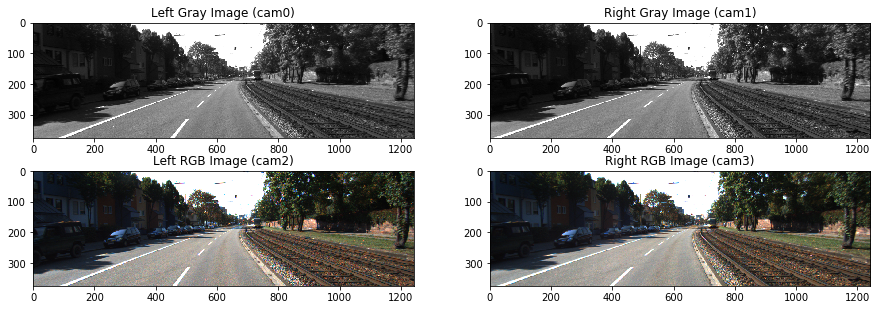

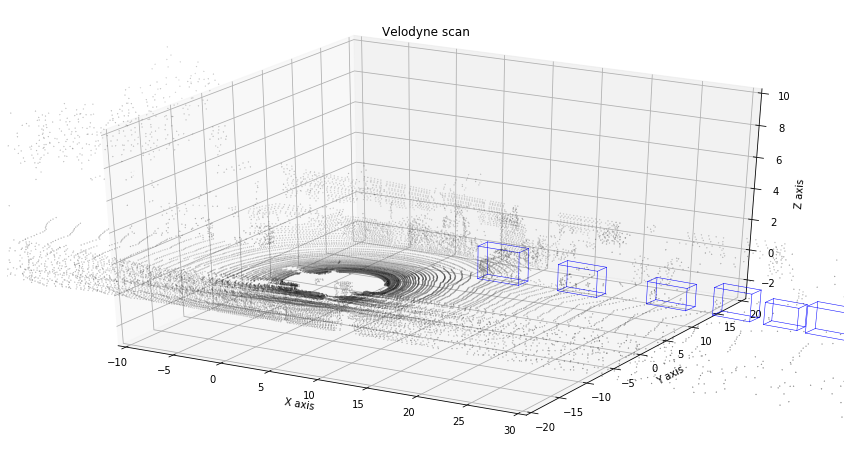

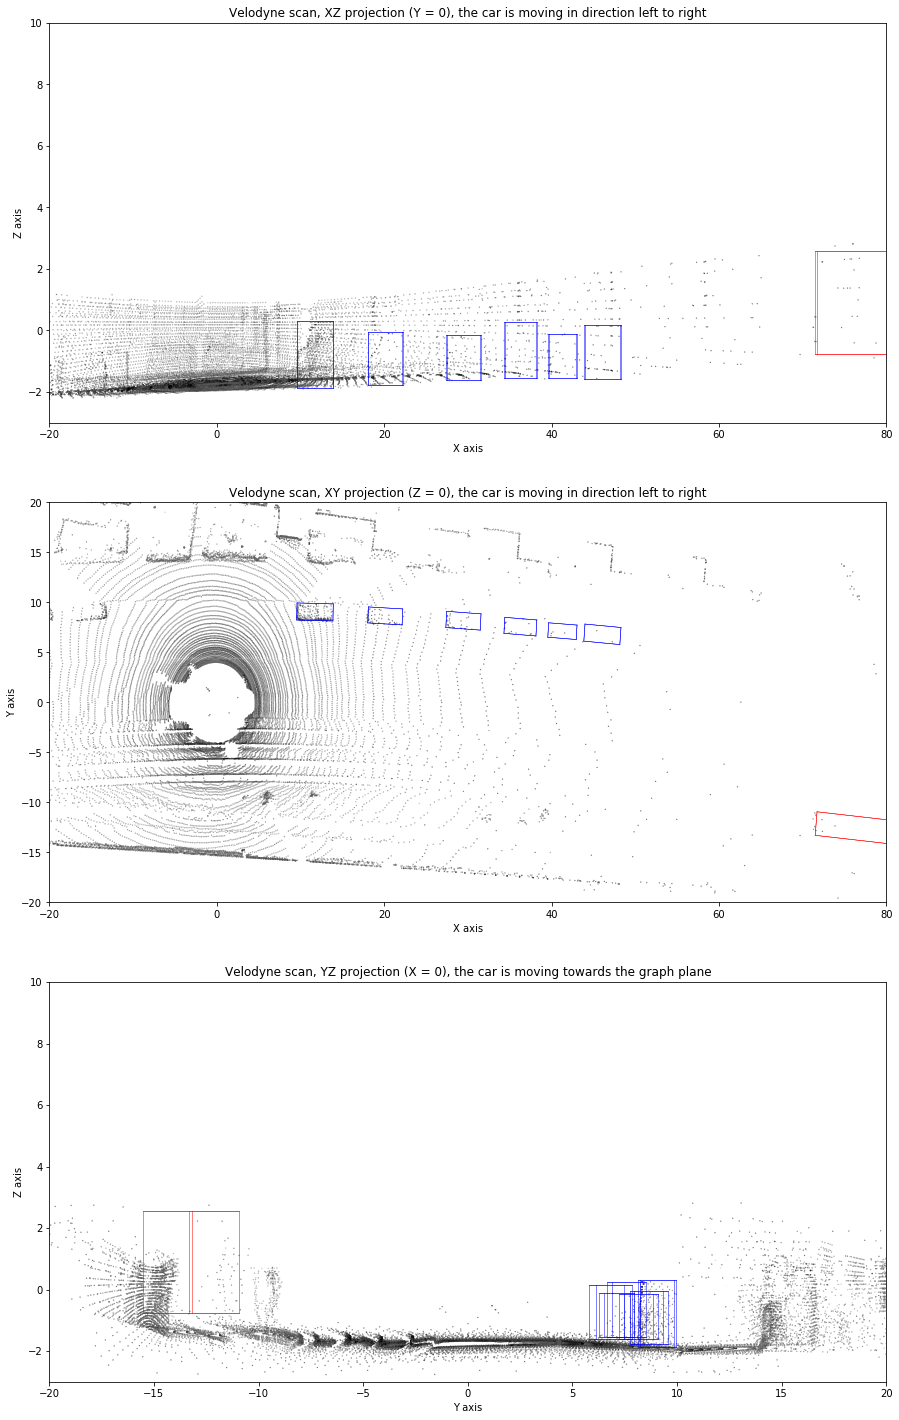

In [34]:
frame = 10

display_frame_statistics(dataset, tracklet_rects, tracklet_types, frame)

In [35]:
from source.utilities import print_progress
from moviepy.editor import ImageSequenceClip

def draw_3d_plot(frame, dataset, tracklet_rects, tracklet_types, points=0.2):
    """
    Saves a single frame for an animation: a 3D plot of the lidar data without ticks and all frame trackelts.
    Parameters
    ----------
    frame           : Absolute number of the frame.
    dataset         : `raw` dataset.
    tracklet_rects  : Dictionary with tracklet bounding boxes coordinates.
    tracklet_types  : Dictionary with tracklet types.
    points          : Fraction of lidar points to use. Defaults to `0.2`, e.g. 20%.

    Returns
    -------
    Saved frame filename.
    """
    dataset_velo = list(dataset.velo)
    
    f = plt.figure(figsize=(12, 8))
    axis = f.add_subplot(111, projection='3d', xticks=[], yticks=[], zticks=[])

    points_step = int(1. / points)
    point_size = 0.01 * (1. / points)
    velo_range = range(0, dataset_velo[frame].shape[0], points_step)
    velo_frame = dataset_velo[frame][velo_range, :]
    axis.scatter(*np.transpose(velo_frame[:, [0, 1, 2]]), s=point_size, c=velo_frame[:, 3], cmap='gray')
    axis.set_xlim3d(*axes_limits[0])
    axis.set_ylim3d(*axes_limits[1])
    axis.set_zlim3d(*axes_limits[2])
    for t_rects, t_type in zip(tracklet_rects[frame], tracklet_types[frame]):
        draw_box(axis, t_rects, axes=[0, 1, 2], color=colors[t_type])
    filename = 'video/frame_{0:0>4}.png'.format(frame)
    plt.savefig(filename)
    plt.close(f)
    return filename

frames = []
n_frames = len(list(dataset.velo))

print('Preparing animation frames...')
for i in range(n_frames):
    print_progress(i, n_frames - 1)
    filename = draw_3d_plot(i, dataset, tracklet_rects, tracklet_types)
    frames += [filename]
print('...Animation frames ready.')

clip = ImageSequenceClip(frames, fps=5)
% time
clip.write_gif('pcl_data.gif', fps=5)

ModuleNotFoundError: No module named 'moviepy'